# Datasets mini exploration

Este notebook fue utilizado para familiarizarse con los conjuntos de datos de ambas categorías del **Bologna Lens Finding Challenge**.

Como los datos son muy pesados, no los voy a incluir en el repositorio, pero pueden ser obtenidos desde los siguientes links.

- [Space Based Training dataset](http://metcalf1.difa.unibo.it/blf-portal/data/SpaceBasedTraining.tar.gz)
- [Ground Based Training dataset](http://metcalf1.difa.unibo.it/blf-portal/data/GroundBasedTraining.tar.gz)

Los cuales fueron descargados el día 23-03-2020. Puede que bajen el sitio, ya que es un back-up del oficial, el cual logré encontrar debido a que la raíz de su servidor es pública (probablemente no sepan esto).

EDIT: al día 05-03-2021 los conjuntos de datos ya no están en el back-up, pero volvieron a estar disponible en la página oficial. Ya reemplacé los links.

## Cargar Librerías

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time

In [2]:
import matplotlib.pyplot as plt
from astropy.visualization import astropy_mpl_style
from astropy.utils.data import get_pkg_data_filename
from astropy.io import fits

plt.style.use(astropy_mpl_style)

In [3]:
from IPython.display import IFrame
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))
pd.set_option('display.max_columns',100)

## Space Based Training Dataset

Este dataset está compuesto por los siguientes archivos:

- `classifications.csv`: el cual tiene el ground truth de las imagenes que contiene, como además tiene algunos parámetros astronómicos que por el momento desconozco.
- `Public/Band1/*.fits`: Imágenes completas del dataset.
- `Private/Band1/NoSourceImage/*.fits`: Imágenes sin la fuente del fenómeno de lensing.
- `Private/Band1/NoLensImage/*.fits`: Imágenes con solo la fuente del fenómeno de lensing.

### Classifications.csv

Primero leemos el archivo csv, el cual lo cargamos en un dataframe de Pandas.

In [5]:
df = pd.read_csv(
    '../../data/space_based_data/SpaceBasedTraining/classifications.csv',
    sep=','
)
df = df.astype({'ID':int})

In [6]:
df.head()

,ID,is_lens,Einstein_area,numb_pix_lensed_image,flux_lensed_image_in_sigma
0,100000,1,8.633760e-10,171,195.429
1,100001,1,1.317890e-10,294,855.589
2,100002,1,4.877250e-12,140,486.113
3,100003,1,1.440160e-09,1500,10467.400
4,100004,0,2.197350e-11,0,0.000


El csv contiene 5 columnas, la primera de ellas es un identificador para cada imagen. La columna `is_lens` es el _ground truth_, indicando si la imagen corresponde a un fenómeno de lensing o no. Las últimas 3 son `Einstein_area`, `numb_pix_lensed_image` y `flux_lensed_image_in_sigma`.

In [7]:
df.shape

(20000, 5)

Por otro lado, el dataset de entrenamiento está compuesto por 20000 imágenes.

La siguiente función recibe como parámetros el dataframe y el nombre de alguna columna de este, para printear algunas medidas de tendencia y graficar el histograma y un boxplot de la columna seleccionada.

In [8]:
def describe_column(df, column):
    desc = df[[column]].describe()
    labels = [i for i in desc.index]
    values = [str(i) for i in desc[column]]
    text= ('\n'.join([ '{}: {}'.format(label,value) for label, value in zip(labels,values)]))
    fig, axes = plt.subplots(1,3,figsize=(25,5))
    axes[0].text(0.25, 0.25, text , fontsize=15)
    axes[0].axis('off')
    axes[0].set_title('Columna: {}'.format(column),fontsize= 20)
    axes[1].hist(df[column])
    axes[1].set_title('Histograma',fontsize=20)
    axes[2].boxplot(df[column])
    axes[2].set_title('Boxplot',fontsize=20)
    plt.show()

#### `is_lens`

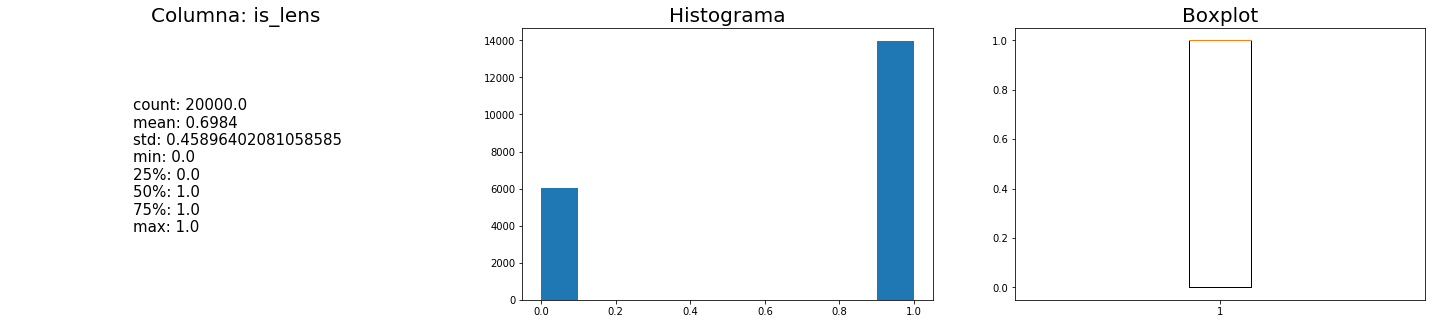

In [9]:
describe_column(df,'is_lens')

Primero, considerando la columna `is_lens` se puede observa que estamos en presencia de un problema desbalanceado, pero para mi sorpresa tiene más casos de lensing que imágenes normales, con 14000 imágenes con label 1 y 6000 con label 0. Hay que tener esto en mente para cuanto se entrene una posible red. Lo bueno de esta situación es que contamos con más ejemplos para el entrenamiento de una futura red GAN.

#### `Einstein_area`

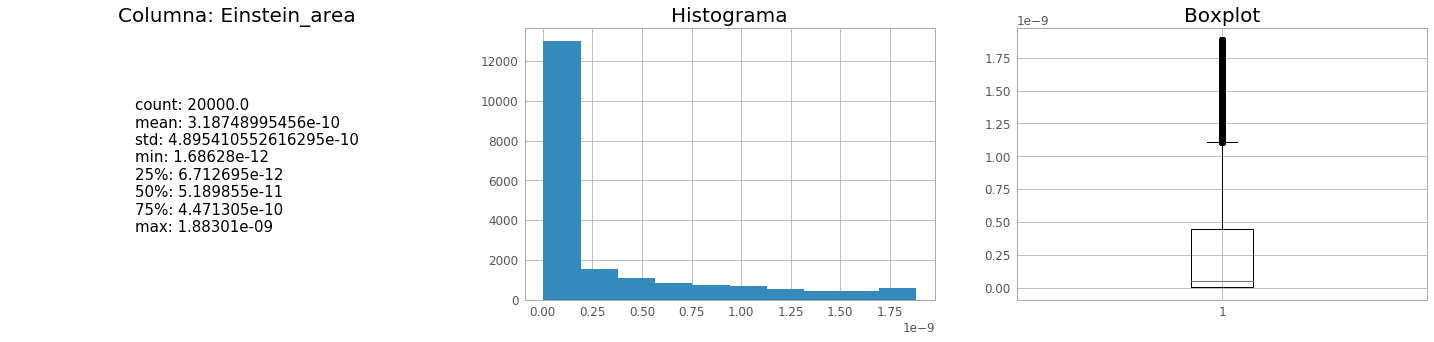

In [9]:
describe_column(df,'Einstein_area')

Para `Einstein_area`, se puede ver que los datos van desde $1.6 x 10^{-12}$ a $1.88 x 10^{-10}$, cuyo histograma está concentrado más cercano al valor mínimo. Viendo el boxplot podemos ver que esta columna cuenta con outliers. Necesitamos analizar esta columna para cada una de las clases.

is_lens == 0


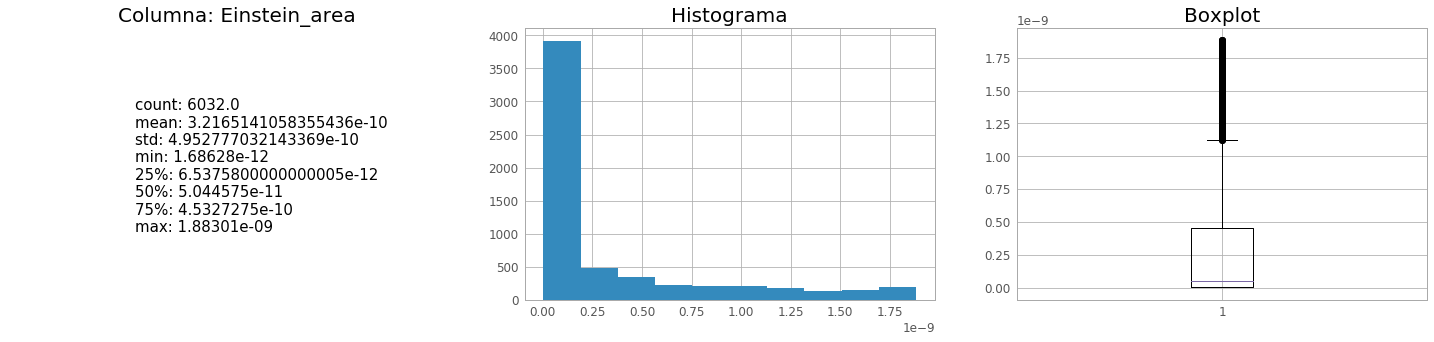

In [10]:
print('is_lens == 0')
describe_column(df[df.is_lens == 0],'Einstein_area')

is_lens == 1


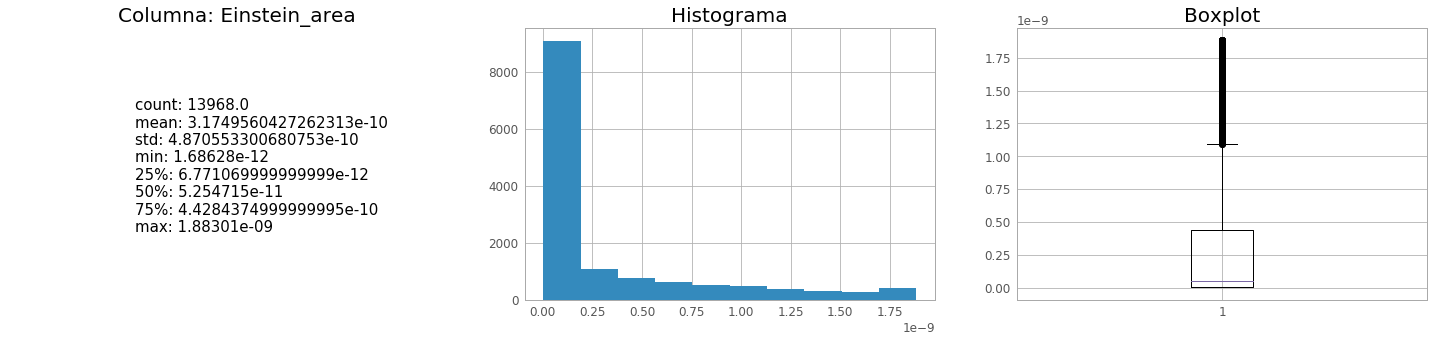

In [11]:
print('is_lens == 1')
describe_column(df[df.is_lens == 1],'Einstein_area')

A simple vista no se aprecia diferencias significativas entre ambos conjuntos, salvo que los cuartiles se mueven levemente, pero los valores máximos y mínimos son iguales. Tampoco se aprecian diferencias a nivel de boxplots.

Según el README adjuntado al dataset de entrenamiento, este campo guarda el área en radianes cuadrados de la región con magnificación negativa. Queda pendiente estudiar este campo en el contexto de lensing gravitacional, pero creo que tiene que ver con un flip de la imagen de la fuente.

#### `numb_pix_lensed_image`

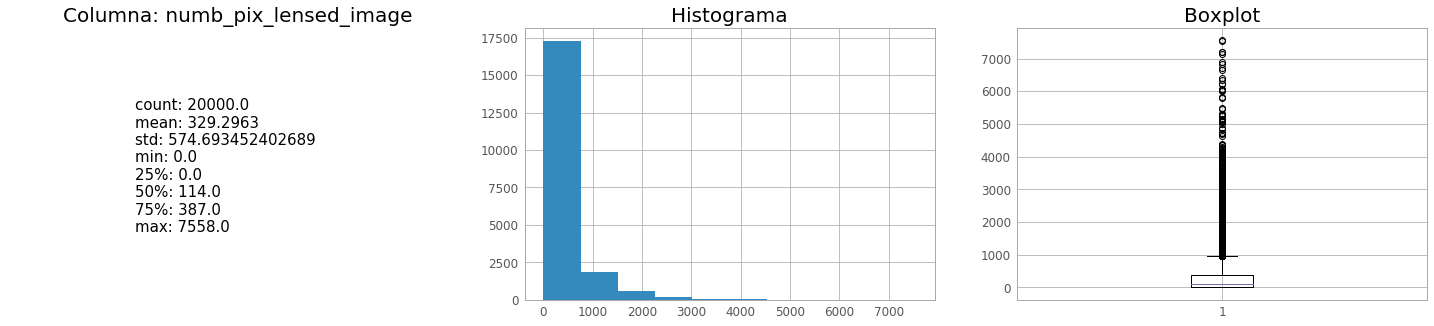

In [12]:
describe_column(df,'numb_pix_lensed_image')

Con la columna `numb_pix_lensed_image`, se puede ver que esta columna va desde 0 a 7558, donde los outliers comienzan desde 1000. Se puede ver que el histograma está concentrado entre 0 y 387.

is_lens == 0


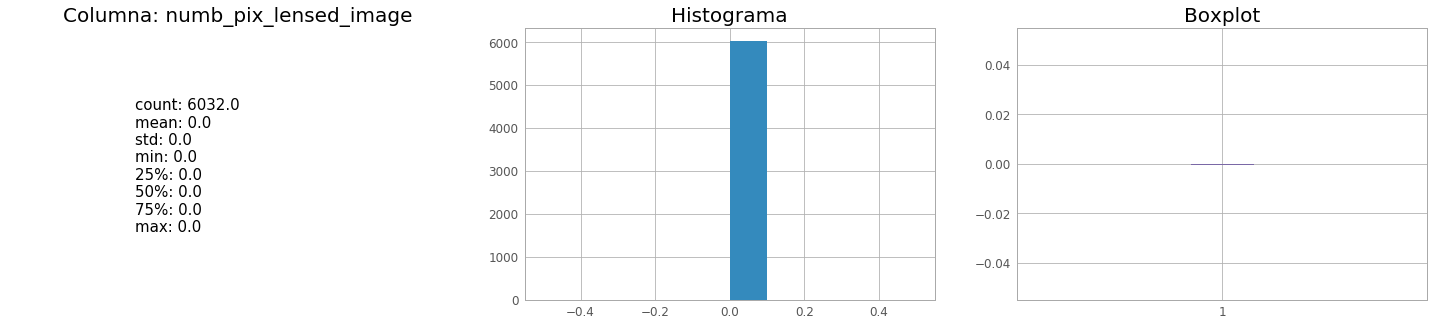

In [13]:
print('is_lens == 0')
describe_column(df[df.is_lens == 0],'numb_pix_lensed_image')

is_lens == 1


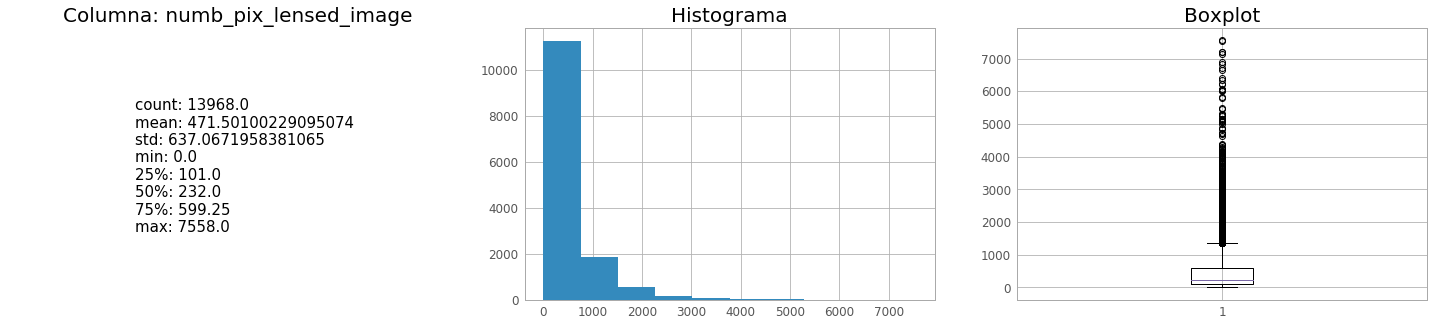

In [14]:
print('is_lens == 1')
describe_column(df[df.is_lens == 1],'numb_pix_lensed_image')

Separando según las clases a clasificar, se puede ver que este campo es 0 cuando no hay lensing, lo cual es obvio una vez leído el README adjunto, el cual indica que esta columna guarda el número de pixeles de la fuente que superan en una desviación estándar al ruido de fondo. Al no considerar los 0, se puede ver como se desplazan los cuartiles, moviendo el bigote superior del boxplot un poco más arriba.

Como esta columna aparece solo para las imágenes con el fenómeno de lensing, se podría usar para condicionar una futura cGAN.

#### `flux_lensed_image_in_sigma`

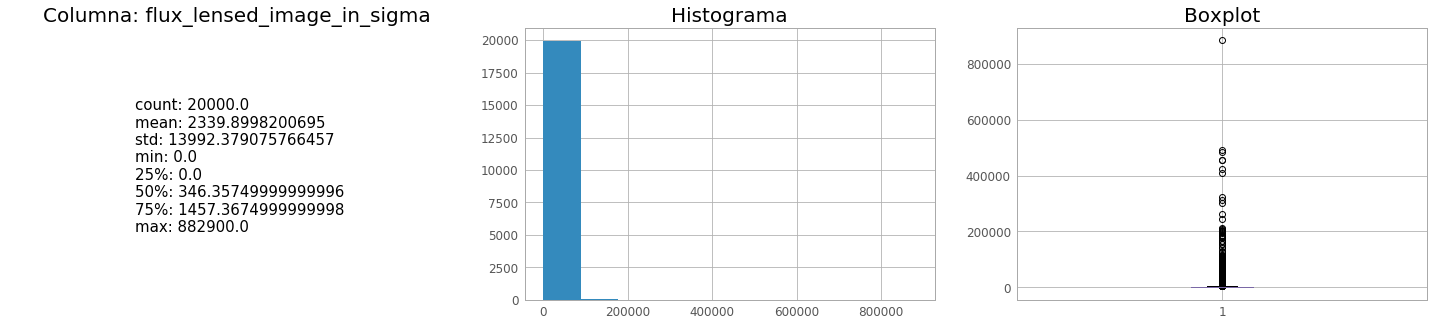

In [15]:
describe_column(df,'flux_lensed_image_in_sigma')

Este campo cuenta con una gran dispersión, ya que puede ir desde 0 a 882900, con una desviación estándar de 13992. El tercer cuartil se ubica en 1457. El histograma esta concentrado en el comienzo. El boxplot muestra presencia de outliers.

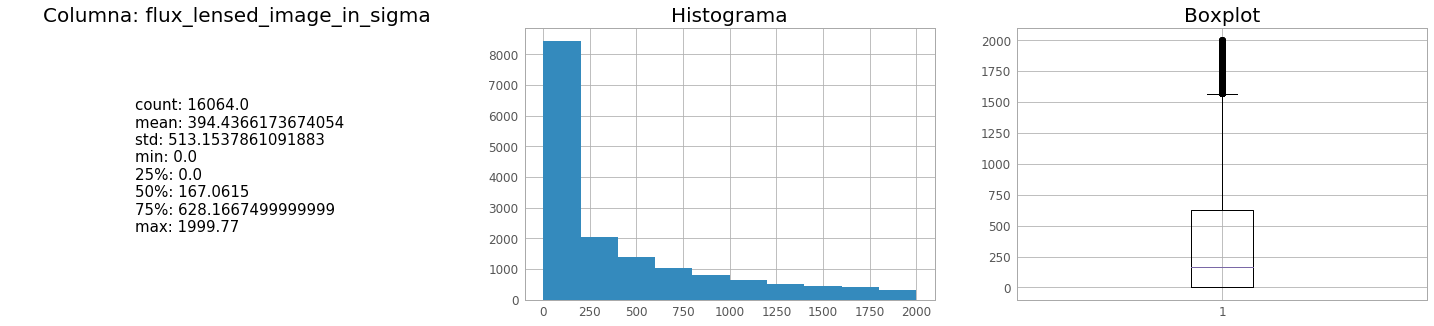

In [16]:
describe_column(df[df.flux_lensed_image_in_sigma <= 2000],'flux_lensed_image_in_sigma')

Considerando solo los valores menores a 2000, se puede ver algo más en el histograma.

is_lens == 0


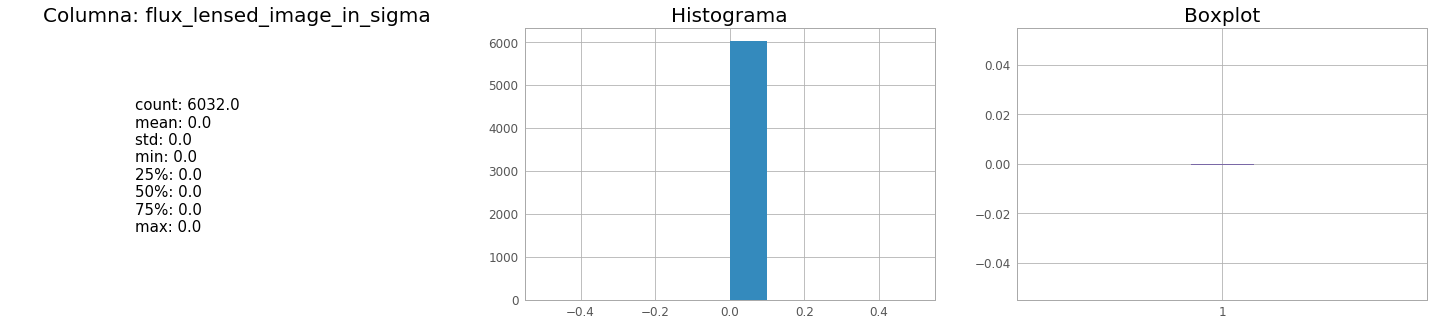

In [17]:
print('is_lens == 0')
describe_column(df[df.is_lens == 0],'flux_lensed_image_in_sigma')

Considerando las imágenes que no cuentan con el fenómeno de lensing, se puede ver que este campo siempre es 0. Según el README este campo tiene que ver con el flujo de pixeles que vienen desde la fuente, así que tiene sentido que este campo sea 0. 

is_lens == 1


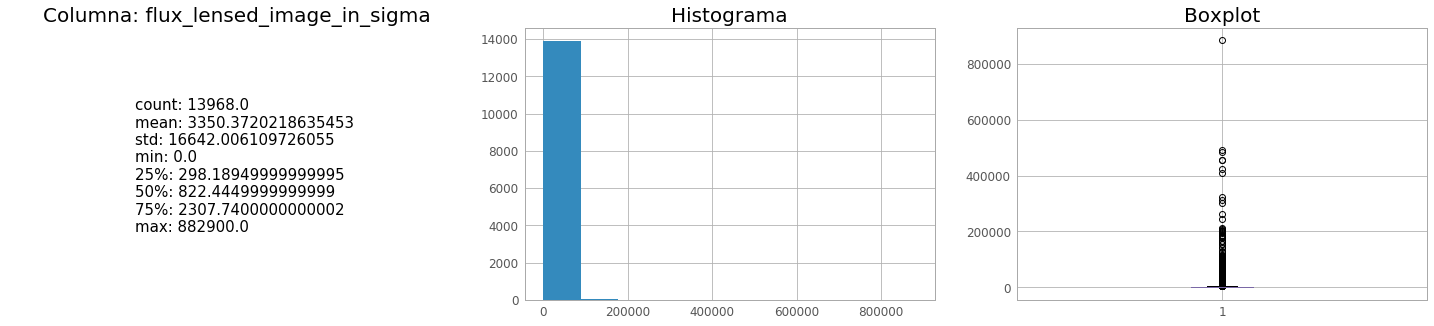

In [18]:
print('is_lens == 1')
describe_column(df[df.is_lens == 1],'flux_lensed_image_in_sigma')

Considerando las imágenes con el fenómeno de lensing, se puede ver una distribución similar a la totalidad de los datos. Algo importante es que este campo puede ser cero aún cuando la imagen presente el fenómeno de lensing.

Este campo también podría ser interesante para una posible cGAN.

### Imágenes Space Based

Primero, necesitamos un decorador para medir el tiempo que demora cargar las imágenes. Hay que considerar que este dataset contiene un solo canal, así que es de esperar que el dataset de la segunda categoría del challenge sea mucho mayor que este.

In [10]:
def timer_decorator(function):
    def override_function(*args, **kw):
        start_time = time.time()
        result = function(*args, **kw)
        elapsed = time.time() - start_time
        print('Tiempo de ejecución: {} segundos'.format(elapsed))
        return result
    return override_function

Luego, podemos pasar a leer las imágenes. Estas se almacenaran en un arreglo, el cual quedará con las siguientes dimensiones: `(20000,101,101,1) #num imagenes, dim_1, dim_2, channels`. 

Primero se leerán las imágenes de la carpeta Public.

In [20]:
path = '../../data/space_based_data/SpaceBasedTraining/Public/Band1/'

In [21]:
@timer_decorator
def read_images(path,df):
    images = list() # number of images, dim_1, dim_2, channels
    for index, row in df.iterrows():
        image_id = int(row['ID'])
        image_file = get_pkg_data_filename(
            '{}imageEUC_VIS-{}.fits'.format(
                path,
                image_id
            )
        )
        image_data = fits.getdata(image_file,ext=0)
        images.append(image_data)
    images = np.asarray(images)
    images = np.reshape(images,(20000,101,101,1)) #reshape to consider 1 channel
    return images

In [22]:
lens_images = read_images(path,df)

Tiempo de ejecución: 425.3572402000427 segundos


In [23]:
lens_images.shape

(20000, 101, 101, 1)

Este proceso demoró aproximadamente 3,5 minutos.

A continuación se leen las imágenes de la carpeta private para compararlas entre sí.

In [24]:
no_lens_path = '../../data/space_based_data/SpaceBasedTraining/Private/Band1/NoLensImage/'
no_lens_images = read_images(no_lens_path,df)

Tiempo de ejecución: 313.30719113349915 segundos


In [25]:
no_source_path = '../../data/space_based_data/SpaceBasedTraining/Private/Band1/NoSourceImage/'
no_source_images = read_images(no_source_path,df)

Tiempo de ejecución: 352.0037019252777 segundos


Las imágenes de la carpeta `Private` demoraron más en cargar, aunque probablemente se deba a la sobrecarga de mi computador.

In [26]:
def show_random_images(df,images,no_lens_images,no_source_images):
    fig, axes = plt.subplots(9,3,figsize=(10,30))
    for i in range(9):
        chosen_image = np.random.randint(
            0,
            images.shape[0]
        )
        lens = df.loc[chosen_image].is_lens
        image_id = chosen_image + 100000
        axes[i][0].imshow(images[chosen_image,:,:,0])
        axes[i][0].set_title('Image {} \n is_lens {}'.format(image_id,lens))
        axes[i][1].imshow(no_lens_images[chosen_image,:,:,0])
        axes[i][1].set_title('No lens Image')
        axes[i][2].imshow(no_source_images[chosen_image,:,:,0])
        axes[i][2].set_title('No Source')
        fig.suptitle('9 Random Images from dataset')
    plt.show()

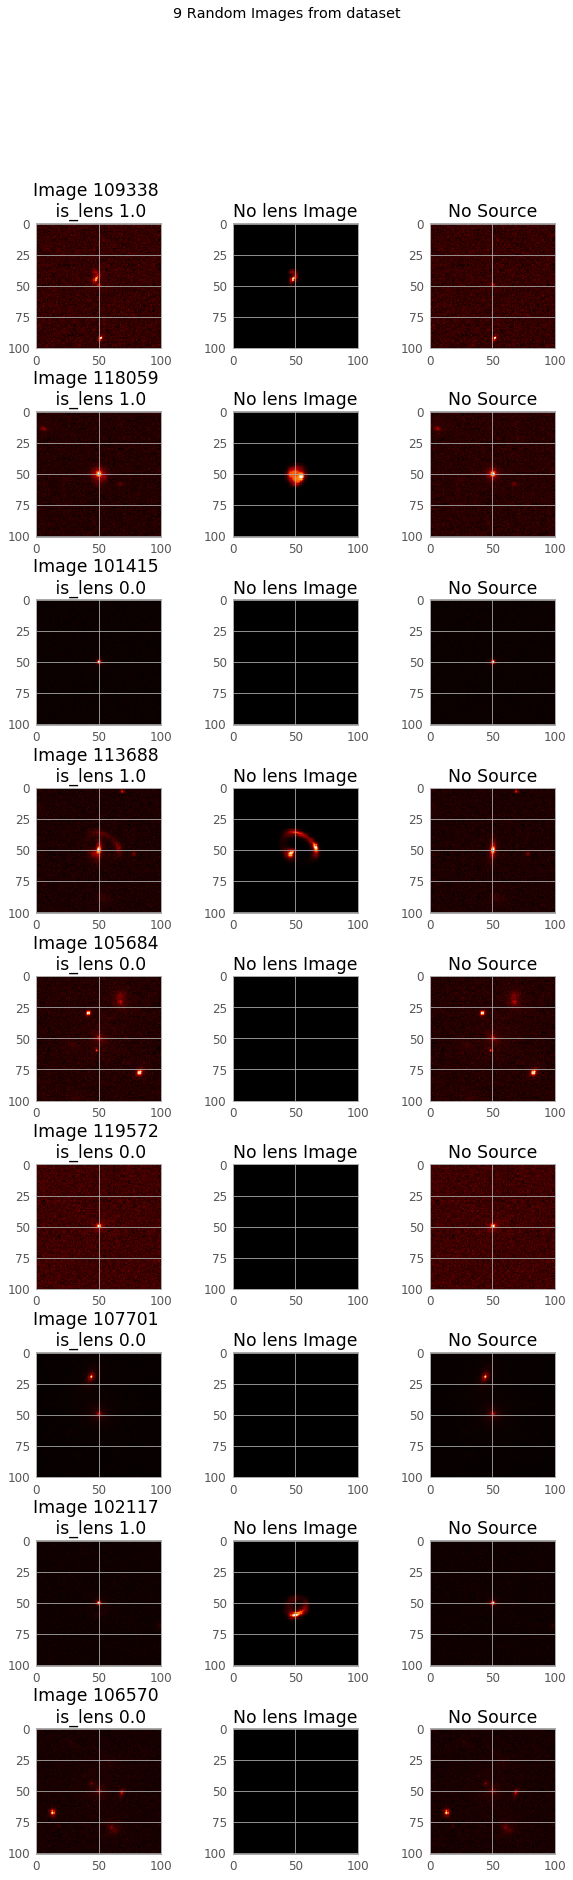

In [27]:
show_random_images(df,lens_images,no_lens_images,no_source_images)

## Space Based Training Dataset

Este dataset está compuesto por los siguientes archivos:

- `classifications.csv`: el cual tiene el ground truth de las imagenes que contiene, además tiene las mismas columnas que el Space Based dataset.
- `Public/Band[i]/*.fits`: Imágenes completas del dataset. Con i tomando valores del 1 al 4.
- `Private/Band[i]/NoSourceImage/*.fits`: Imágenes sin la fuente del fenómeno de lensing. Con i tomando valores del 1 al 4.
- `Private/Band[i]/NoLensImage/*.fits`: Imágenes con solo la fuente del fenómeno de lensing. Con i tomando valores del 1 al 4.

Este dataset cuenta con imágenes con 4 bandas (R, I, G, U). Voy a necesitar ayuda para entender estos canales, para ver como visualizar las imágenes. Igual, he encontrado un par de métodos para la visualización [LINK](https://docs.astropy.org/en/stable/visualization/rgb.html)

### Classifications.csv

In [11]:
df_ground = pd.read_csv(
    '../../data/ground_based_data/GroundBasedTraining/classifications.csv',
    sep=','
)
df_ground = df_ground.astype({'ID':int})

In [5]:
df_ground.head()

,ID,is_lens,Einstein_area,numb_pix_lensed_image,flux_lensed_image_in_sigma
0,100000,1,6.039480e-10,804,3714.6800
1,100001,0,4.700830e-11,0,0.0000
2,100002,1,7.180970e-11,51,57.6093
3,100003,1,1.764110e-11,347,18815.4000
4,100004,0,2.034950e-09,0,0.0000


In [12]:
df.head()

,ID,is_lens,Einstein_area,numb_pix_lensed_image,flux_lensed_image_in_sigma
0,100000,1,8.633760e-10,171,195.429
1,100001,1,1.317890e-10,294,855.589
2,100002,1,4.877250e-12,140,486.113
3,100003,1,1.440160e-09,1500,10467.400
4,100004,0,2.197350e-11,0,0.000


Considerando los 5 primeros registros de ambos dataset, podemos observar que no corresponden a las mismas simulaciones pero en distintos canales, por lo que hay que analizar nuevamente cada una de estas columnas.

#### `is_lens`

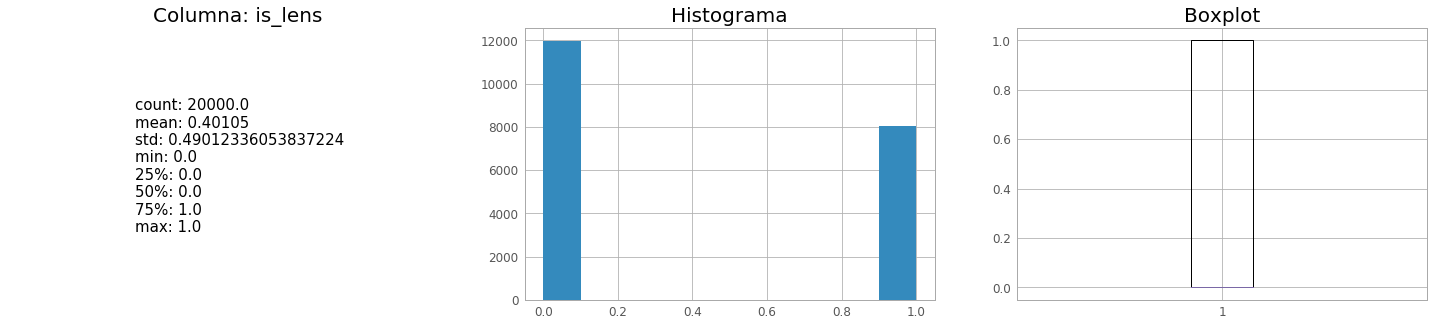

In [31]:
describe_column(df_ground,'is_lens')

Considerando la columna `is_lens`, podemos ver que el problema sigue siendo desbalanceado, pero en este caso se cuenta con más imágenes que no presentan el fenómeno de lensing que las que sí lo presentan. En este dataset se tienen 8000 imágenes de lensing y 12000 imágenes sin este fenómeno, una proporción de 40 a 60 porciento.

#### `Einstein_area`

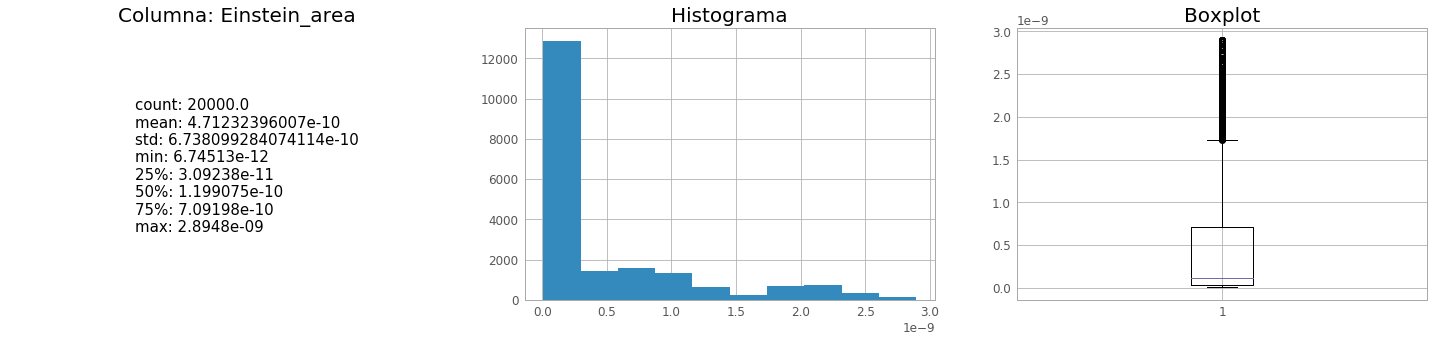

In [32]:
describe_column(df_ground,'Einstein_area')

La columna `Einstein_area` va desde $6.7 x 10^{-12}$ a $2.8 x 10^{-9}$, lo cual son valores más altos que los presentes en el Space Based dataset. Por lo mismo, el corte para considerar un dato como outlier es mayor ($1.75 x 10^{-9}$ vs $1.1 x 10^{-9}$ aproximadamente).

Al igual que el primer dataset, el histograma está concentrado en su comienzo.

is_lens == 0


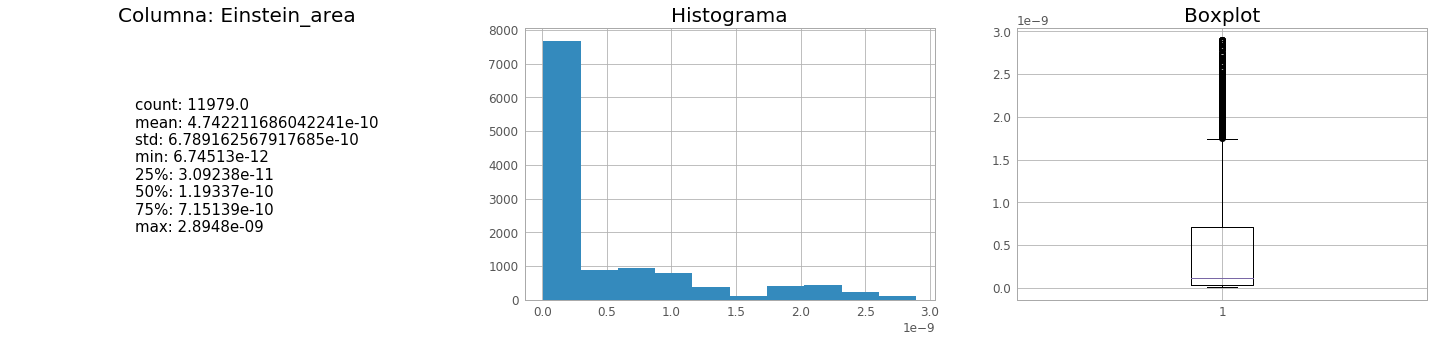

In [33]:
print('is_lens == 0')
describe_column(df_ground[df_ground.is_lens == 0],'Einstein_area')

is_lens == 1


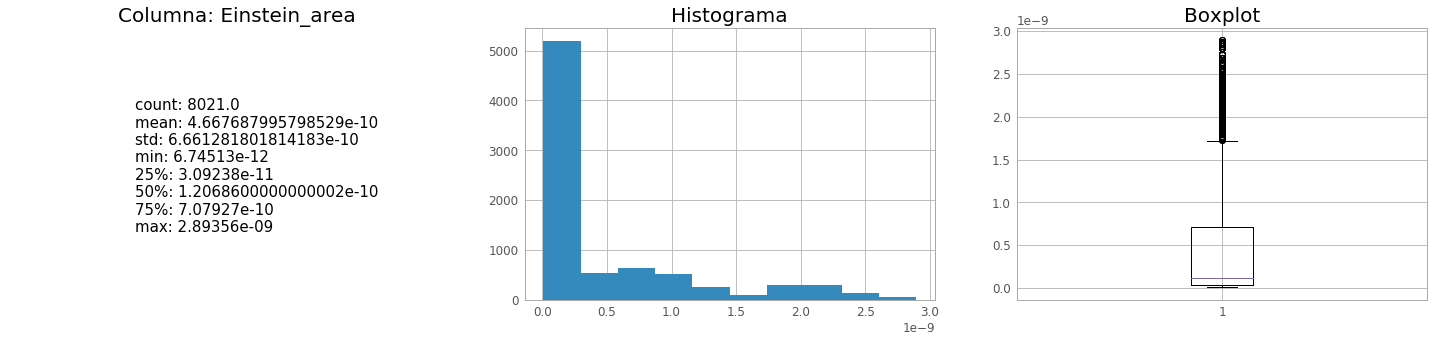

In [34]:
print('is_lens == 1')
describe_column(df_ground[df_ground.is_lens == 1],'Einstein_area')

Considerando las clases del problema, los histograma se distribuyen de manera muy similar. Esto se puede ver en el siguiente histograma.

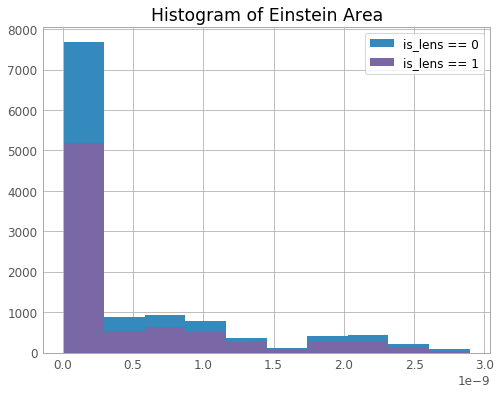

In [35]:
plt.figure()
plt.hist(df_ground[df_ground.is_lens == 0]['Einstein_area'])
plt.hist(df_ground[df_ground.is_lens == 1]['Einstein_area'])
plt.legend(['is_lens == 0', 'is_lens == 1'])
plt.title('Histogram of Einstein Area')
plt.show()

#### `numb_pix_lensed_image`

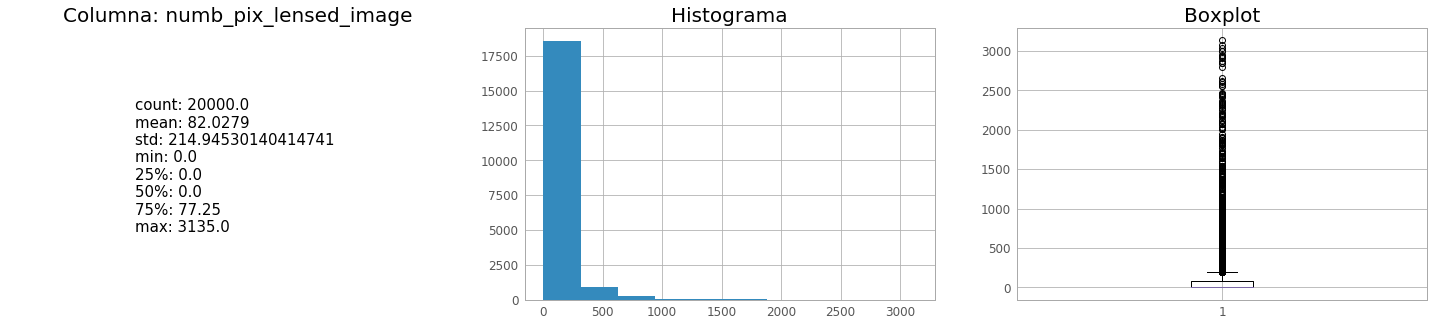

In [36]:
describe_column(df_ground,'numb_pix_lensed_image')

Esta columna toma los valores desde el 0 a 3135, lo que es una disminución con respecto al valor máximo del Space Based dataset, el cuall era de 7558. Los outliers comienzan desde los 115.78, considerando el threshold como $1,5 * IQR$.

Como sabemos que este es un valor presente en las imágenes que presentan el fenómeno de lensing, se graficará solo para dichas imágenes.

is_lens == 1


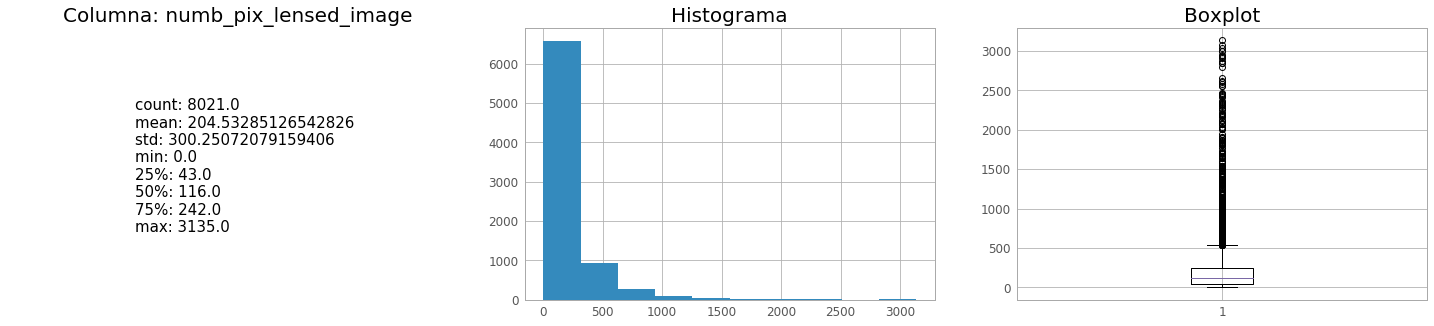

In [37]:
print('is_lens == 1')
describe_column(df_ground[df_ground.is_lens == 1],'numb_pix_lensed_image')

Sin considerar las imágenes que no son de lensing, se puede ver que los outliers comienzan desde aproximadamente los 500 pixeles. Se me ocurrió pasarlo a escala logaritmica, podría servir para algo quizás a futuro.

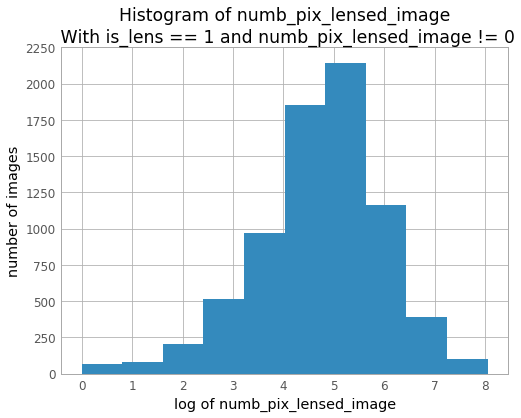

In [38]:
plt.figure()
plt.title("Histogram of numb_pix_lensed_image\n With is_lens == 1 and numb_pix_lensed_image != 0")
plt.hist(np.log(df_ground[(df_ground.is_lens == 1)&(df_ground.numb_pix_lensed_image != 0)]['numb_pix_lensed_image']))
plt.ylabel("number of images")
plt.xlabel("log of numb_pix_lensed_image")
plt.show()

#### `flux_lensed_image_in_sigma`

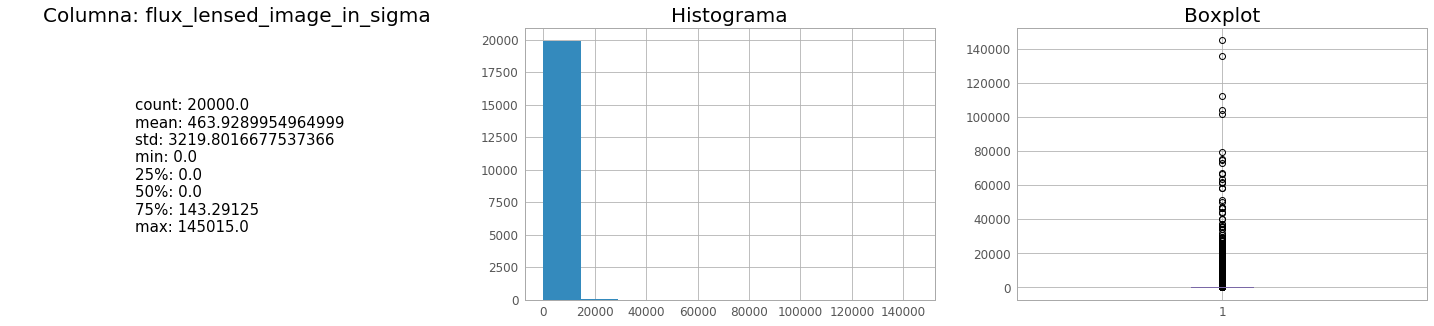

In [39]:
describe_column(df_ground,'flux_lensed_image_in_sigma')

Con esta columna se da una situación muy similar a la del Space Based dataset.

is_lens == 1


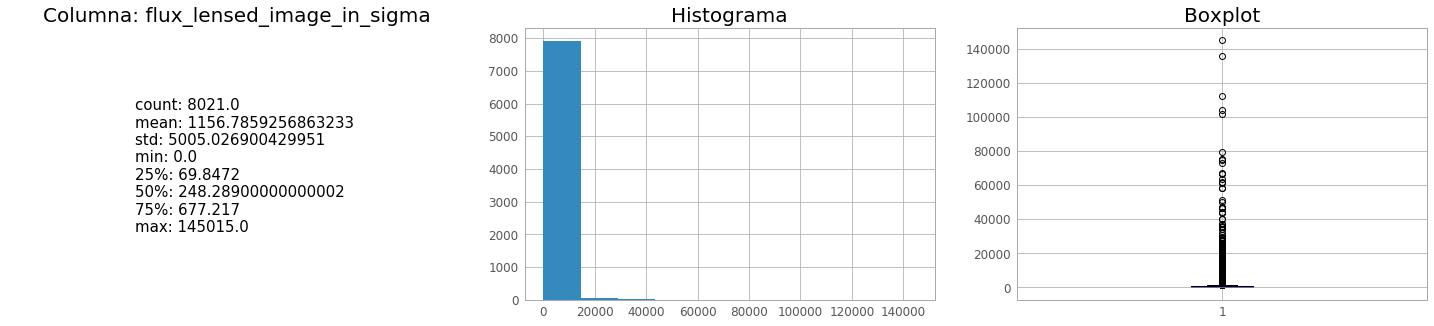

In [40]:
print('is_lens == 1')
describe_column(df_ground[df_ground.is_lens == 1],'flux_lensed_image_in_sigma')

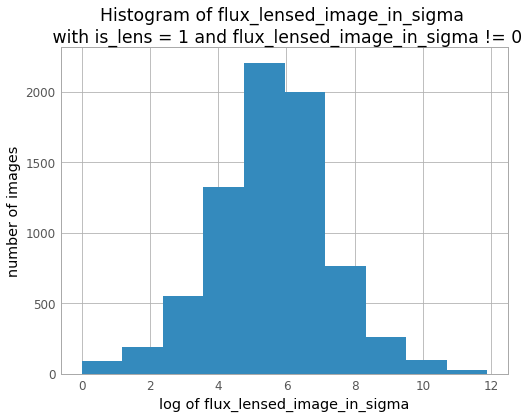

In [41]:
plt.figure()
plt.title('Histogram of flux_lensed_image_in_sigma \n with is_lens = 1 and flux_lensed_image_in_sigma != 0')
plt.hist(np.log(df_ground[
    (df_ground.is_lens == 1)&
    (df_ground.flux_lensed_image_in_sigma != 0)
]['flux_lensed_image_in_sigma']))
plt.ylabel("number of images")
plt.xlabel("log of flux_lensed_image_in_sigma")
plt.show()

### Imágenes Ground Based

Al igual que con el dataset Space Based, necesitamos una función para cargar las imágenes de este dataset, considerando las cuatro bandas que contienen.

In [13]:
@timer_decorator
def read_ground_based_images(path,df):
    images = list() # number of images, dim_1, dim_2, channels
    bands = ['R','I','G','U']
    for index, row in df.iterrows():
        image_id = int(row['ID'])
        image_array = np.zeros((101, 101,4))
        for band_number, band in enumerate(bands):
            image_file = get_pkg_data_filename(
                '{}Band{}/imageSDSS_{}-{}.fits'.format(
                    path,
                    band_number + 1,
                    band,
                    image_id
                )
            )
            image_data = fits.getdata(image_file,ext=0)
            image_array[:,:,band_number] = image_data
        images.append(image_array)
    images = np.asarray(images)
    return images

In [14]:
path_ground_based = '../../data/ground_based_data/GroundBasedTraining/Public/'

In [ ]:
ground_based_lens_images = read_ground_based_images(
    path_ground_based,
    df_ground
)

En cargar los datos se demoró casi una hora, esto no es bueno para mi, ya que cada vez que quiera comenzar a trabajar se demorará un tiempo similar.


Necesito encontrar una manera de visualizar las imágenes en 4 canales. Por ahora, visualizaré cada canal por separado.

In [48]:
def show_ground_random_images(df,images):
    fig, axes = plt.subplots(9,4,figsize=(15,40))
    for row in range(9):
        chosen_image = np.random.randint(
            0,
            images.shape[0]
        )
        lens = df.loc[chosen_image].is_lens
        image_id = chosen_image + 100000
        axes[row][0].imshow(images[chosen_image,:,:,0])
        axes[row][1].imshow(images[chosen_image,:,:,1])
        axes[row][2].imshow(images[chosen_image,:,:,2])
        axes[row][3].imshow(images[chosen_image,:,:,3])
        axes[row][0].set_title(
            'Image: {}\n is_lens: {} \n R'.format(
                image_id,
                lens
            )
        )
        axes[row][1].set_title('I')
        axes[row][2].set_title('G')
        axes[row][3].set_title('U')
    plt.show()

A continuación se muestran 9 imágenes aleatorias desde el set de imágenes. Cada fila corresponde a una imagen, mientras cada columna es una canal: la primera corresponde al canal R, la segunda al canal I, la tercera al canal G, y por último, la cuarta corresponde al canal U.

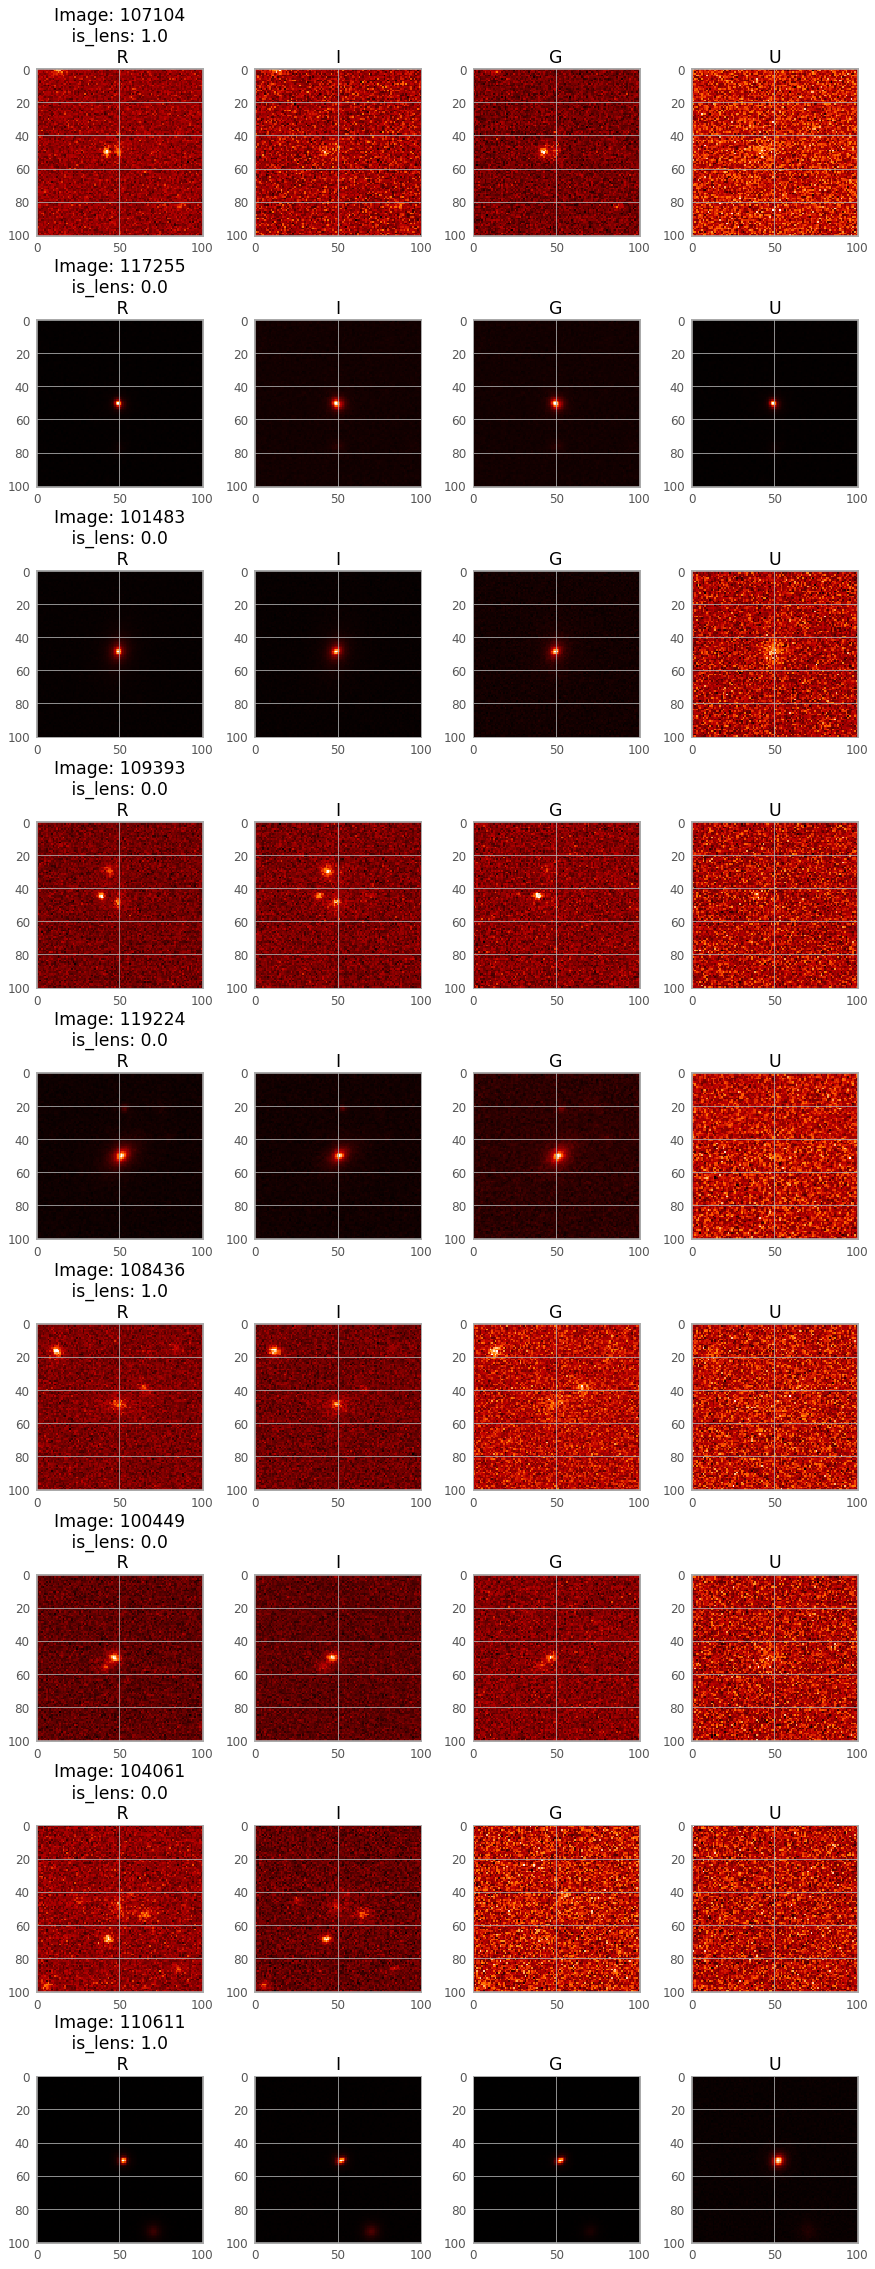

In [49]:
show_ground_random_images(df_ground,ground_based_lens_images)